In [3]:
'''
Multi-class Classification Regular Neural Net for MNIST Dataset Using Gradient Descent
    Implementation by Yousef Jaber
    Method learned from Andrew Ng
'''

#Imports
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import pickle

In [4]:
'''
-------------------STEP 0: LOAD DATASET--------------------- 
'''

#load data
x_training_set = np.loadtxt("mnist_train(1).csv", delimiter = ",")
x_test_set = np.loadtxt("mnist_test.csv", delimiter = ",")

In [227]:
#split labels
y_training_labels = np.asfarray(x_training_set[:, :1])
y_test_labels = np.asfarray(x_test_set[:, :1])

#get rid of 0 input values in image pixel arrays
x_training_images = np.asfarray(x_training_set[:, 1:]) * 0.99/255 + 0.01
x_test_images = np.asfarray(x_test_set[:, 1:])* 0.99/255 + 0.01

#One Hot Encode the Labels for training and test sets
lr = np.arange(10)    #Since there are 10 different labels, 0-9
y_training_encoded = (lr == y_training_labels).astype(np.float)
y_test_encoded = (lr == y_test_labels).astype(np.float)

In [228]:
#save data in binary format for faster load
with open("pickeled_mnist_data.pkl", "bw") as fh:
    data = (x_training_images, 
            x_test_images,
            y_training_labels,
            y_test_labels,
            y_training_encoded,
            y_test_encoded)
    pickle.dump(data, fh)
    
#reload data with pickle
x_training_images = data[0] 
x_test_images = data[1]
y_training_labels = data[2]
y_test_labels = data[3]
y_training_encoded = data[4]
y_test_encoded = data[5]

#transpose the arrays so they are of width no_of_samples
x_training_images = x_training_images.T
x_test_images = x_test_images.T
y_training_encoded = np.array(y_training_encoded).T
y_test_encoded = np.array(y_test_encoded).T

print("--------Data Loaded-----------")
print("Training Data shape: " + str(x_training_images.shape))
print("Test Data shape: " + str(x_test_images.shape))
print("Training Labels Shape: " + str(y_training_labels.shape))
print("Test Labels Shape: " + str(y_test_labels.shape))
print("Train Labels Encoded: " + str(y_training_encoded.shape))
print("Test Labels Encoded: " + str(y_test_encoded.shape))

--------Data Loaded-----------
Training Data shape: (784, 60000)
Test Data shape: (784, 10000)
Training Labels Shape: (60000, 1)
Test Labels Shape: (10000, 1)
Train Labels Encoded: (10, 60000)
Test Labels Encoded: (10, 10000)


In [445]:
print(x_training_images[500:510,4000:40010])

[[0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 ...
 [0.01       0.01       0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.44094118 0.01       ... 0.01       0.01       0.01      ]
 [0.01       0.99611765 0.01       ... 0.01       0.01       0.01      ]]


In [229]:
'''
----------STEP 1: DEFINE NEURAL NET ARCHITECTURE-------------
'''

no_training_samples = x_training_images.shape[1]
no_features = x_training_images.shape[0]

#Number of units per layer (not counting input layer), specified when model is created
layer_dimensions = []       

In [230]:
'''
------------STEP 2: INITIALIZE PARAMETERS--------------------
'''

def initialize_parameters(layer_dims, no_features, no_training_samples):

    '''
    Fill weight matrix with random weights and bias col vector with zeros
    for each layer in the network
    
    arguments:
        layer_dims  -- an array of hidden units per layer
        no_features -- amount of features for input matrix X
        no_training_samples -- length of training set

    returns:
        weight_dict -- a dictionary of weight matrices for each layer
        bias_dict   -- a dictionary of bias col vectors for each layer
    '''
    
    weight_dict = {}
    bias_dict = {}

    #first weight matrix gets second dim from no of features
    weight_dict["W1"] = np.random.randn(layer_dims[0],no_features) * 0.01
    bias_dict["B1"]   = np.zeros((layer_dims[0], 1))
    
    for layers in range(2, len(layer_dims) + 1, 1):
        weight_dict["W" + str(layers)] = np.random.randn(layer_dims[layers - 1], layer_dims[layers - 2]) * 0.01
        bias_dict["B" + str(layers)] = np.zeros((layer_dims[layers-1], 1))
                                                                              
    return weight_dict, bias_dict


In [231]:
'''
---------------------STEP 3: FORWARD PROPAGATION--------------------
'''

def calculate_activation(Z, activation_string):

    '''
    Calculate Relu or Softmax 

    arguments:
        Z -- WX+B matrix for layer specified 
        activation_string -- which activation to use

    returns:
        A -- g(Z), where g is activation function
    '''

    if (activation_string == "relu"):
        return np.maximum(0, Z)

    elif (activation_string == "softmax"):
        #print("Summing shape: " + str(Z.shape))
        return np.exp(Z)/np.sum(np.exp(Z), axis = 0, keepdims = True)

def forward_propogate(weight_dict, bias_dict, x_training_set, layer_dims):
    
    '''
    Calculates w.Tx + b and activation for each layer

    arguments:
        weight_dict -- a dictionary of weight matrices for each layer
        bias_dict   -- a dictionary of bias col vectors for each layer
        x_training_set -- the training set
        layer_dims  -- an array of hidden units per layer

    returns:
        z_dict -- a dictionary mapping WX+B for each layer
        y_hat  -- the final output(prediction) of the model
        activation_dict -- a dictionary mapping activation(Z) for each layer
    '''

    z_dict = {}
    y_hat  = {}
    activation_dict = {"A0":x_training_set}

    #relu layers (L-2, ie up until softmax layer)
    for layers in range(len(layer_dims) - 1):
        '''
        print("W" + str(layers + 1) + " should have shape " + str((layer_dims[layers+1], activation_dict["A" + str(layers)].shape[0])) + " but has shape: " + str(weight_dict["W" + str(layers + 1)].shape))
        #make sure shapes are correct
        assert(weight_dict["W" + str(layers + 1)].shape == (layer_dims[layers+1], activation_dict["A" + str(layers)].shape[0]))  
        assert(activation_dict["A" + str(layers)].shape == (layer_dims[layers+1], activation_dict["A" + str(layers)].shape[1]))
        assert(bias_dict["B" + str(layers + 1)].shape == (layer_dims[layers+1], 1))
        '''
        
        z_dict["Z" + str(layers + 1)] = np.dot(weight_dict["W" + str(layers + 1)], activation_dict["A" + str(layers)]) + bias_dict["B" + str(layers + 1)]  # Z^l = W^l . A^l-1 + B^l
        activation_dict["A" + str(layers + 1)] = calculate_activation(z_dict["Z" + str(layers + 1)], "relu")
        
        
    #softmax layer (layer L)
    softmax_layer = len(layer_dims)
    z_dict["Z" + str(softmax_layer)] = np.dot(weight_dict["W" + str(softmax_layer)], activation_dict["A" + str(softmax_layer - 1)]) + bias_dict["B" + str(softmax_layer)]
    
    activation_dict["A" + str(softmax_layer)] = calculate_activation(z_dict["Z" + str(softmax_layer)], "softmax")
    y_hat = activation_dict["A" + str(softmax_layer)]
    

    
    return z_dict, y_hat, activation_dict


In [232]:
'''
----------------------------- STEP 4: CALCULATE COST -------------------------------
'''

def calculate_cost(y_hat, y_labels):
    '''
    Sum of Losses for each training sample

    arguments:
        y_hat    -- model prediction                                #Both have shape (c, m)
        y_labels -- labels for training or test samples

    returns:
        cost -- calculated cost
    '''
    if(y_hat.shape[0] != (10)):
        print("Shapes of Ys")
        print(y_hat.shape)
        print(y_labels.shape)
    
    m = y_labels.shape[1]
    
    loss = - np.sum(y_labels * np.log(y_hat), axis = 0, keepdims = True)
    cost = 1/m * np.sum(loss, axis = 1)
    
    return cost



In [233]:
'''
----------------------------- STEP 5: BACKWARD PROPAGATION -------------------------------
'''

def relu_backward(dA, Z):
    '''
    dZ = dA * g'(Z) where g is the Relu activation

    arguments:
        dA -- dA is calculated in the previous layer with WT.dZ
        Z  -- the linear output (WT.Z) calculated from forward prop

    returns:
        dZ -- used to calculate dB and dW 
    '''
    
    return np.multiply(dA, np.where(Z > 0, 1, 0))


def back_propagate(y_labels_encoded, activation_dict, layer_dims, weight_dict, z_dict, y_hat):
    '''
    Calculate the gradients for all of the weights and biases in each layer

    rguments: 
        y_labels_encoded -- one hot encoded labels
        activation_dict --  activations calculated from forward prop
        layer_dims -- created when specifying neural net architecture
        weight_dict -- weights from forward prop
        z_dict -- Z's calulcated from forward prop
        y_hat  -- predictions from forward prop

    returns:
        gradients -- dZ, dW, and dB for all of the layers
    '''

    gradients = {}
    m = y_hat.shape[1]

    #first calculate gradients for softmax layer, including dA_prev, the activation gradient for the preceding layer
    dZ = y_hat - y_labels_encoded
    gradients["dZ" + str(len(layer_dims))] = dZ
    gradients["dW" + str(len(layer_dims))] = 1/m * np.dot(dZ, activation_dict["A" + str(len(layer_dims) - 1)].T)
    gradients["dB" + str(len(layer_dims))] = 1/m * np.sum(dZ, axis = 1, keepdims = True)
    gradients["dA" + str(len(layer_dims) - 1)] = np.dot(weight_dict["W" + str(len(layer_dims))].T, dZ)
    
    
    for layers in reversed(range(1, len(layer_dims), 1)):
        i = str(layers)
        
        gradients["dZ" + i] = relu_backward(gradients["dA" + i], z_dict["Z" + i])
        dZ = gradients["dZ" + i]
        
        gradients["dW" + i] = 1/m * np.dot(dZ, activation_dict["A" + str(layers - 1)].T)
        gradients["dB" + i] = 1/m * np.sum(dZ, axis = 1, keepdims = True)
        gradients["dA" + str(layers - 1)] = np.dot(weight_dict["W" + i].T, dZ)
    
    return gradients

In [266]:
'''
------------------- STEP 6: UPDATE PARAMETERS --------------------------
'''

def update_parameters(learning_rate, gradients, weight_dict, bias_dict, layer_dims):
    '''
    Update values in parameter dictionaries using gradient values and learning rate

    arguments: 
        learning_rate -- alpha coefficient in update equation
        gradients  -- gradients from back prop
        weight_dict   -- weights
        bias_dict     -- biases
        layer_dims    -- model architecture
        
    returns:
        weight_dict   -- weights
        bias_dict     -- biases
    '''
    
    for layers in range(len(layer_dims)):

        weight_dict["W" + str(layers + 1)] = np.subtract(weight_dict["W" + str(layers + 1)], learning_rate * gradients["dW" + str(layers + 1)])
        bias_dict["B" + str(layers + 1)]   = np.subtract(bias_dict["B" + str(layers + 1)], learning_rate * gradients["dB" + str(layers + 1)])
    return weight_dict, bias_dict

In [235]:
'''
------------------ STEP 7: CREATE MODEL AND PREDICT ---------------------
'''

def create_model(layer_dimensions, training_set_X, training_labels_encoded_Y, learning_rate, num_iterations, print_every):
    '''
    Pull all the strings together
    '''
    
    print("NN Dimensions: " + str(layer_dimensions))
    print("Dataset shape: " + str(training_set_X.shape))
    print("Labels Shape: " + str(training_labels_encoded_Y.shape))
    
    weight_dict, bias_dict = initialize_parameters(layer_dimensions, training_set_X.shape[0], training_set_X.shape[1])
    costs = np.array([])

    for it in range(num_iterations):
        z_dict, y_hat, activation_dict = forward_propogate(weight_dict, bias_dict, training_set_X, layer_dimensions)
        costs = np.append(costs, calculate_cost(activation_dict["A" + str(len(layer_dimensions))], training_labels_encoded_Y))
        gradients = back_propagate(training_labels_encoded_Y, activation_dict, layer_dimensions, weight_dict, z_dict, y_hat)
        weight_dict, bias_dict = update_parameters(learning_rate, gradients, weight_dict, bias_dict, layer_dimensions)

        if (it % print_every == 0):
            print("The cost after iteration " + str(it) + " is " + str(costs[it]))

    print("After model trained. y_hat shape: " + str(activation_dict["A" + str(len(layer_dimensions))].shape))
    print("Length of weight dict " + str(len(weight_dict)))
    
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return weight_dict, bias_dict

def predict(weight_dict, bias_dict, test_set_X, layer_dimensions, test_labels_Y_encoded):
    '''
    Run forward propgation on test set and compare to test labels
    '''
    print("NN Dimensions: " + str(layer_dimensions))
    print("Dataset shape: " + str(test_set_X.shape))
    print("Labels Shape: " + str(test_labels_Y_encoded.shape))
    
    z_dict, y_hat, activation_dict = forward_propogate(weight_dict, bias_dict, test_set_X, layer_dimensions) 
    cost = calculate_cost(y_hat, test_labels_Y_encoded)
    
    print("Yhat shape: " + str(y_hat.shape))
    #convert y_hat to an array of actual numbers
    y_hat_numbers = np.argmax(y_hat, axis = 0)
    
    #how many matched values between prediction and test labels
    accuracy = np.sum(y_hat_numbers.T == y_test_labels.T) / test_labels_Y_encoded.shape[1] * 100
    
    print("Final cost: " + str(cost))
    print("Final accuracy: " + str(accuracy) + " %")
    
    return y_hat

NN Dimensions: [397, 10]
Dataset shape: (784, 60000)
Labels Shape: (10, 60000)
The cost after iteration 0 is 2.3030108738766275
The cost after iteration 100 is 0.7661136042722223
The cost after iteration 200 is 0.46451957470500377
The cost after iteration 300 is 0.3869922609041496
The cost after iteration 400 is 0.3507670693813656
The cost after iteration 500 is 0.3281425224949228
The cost after iteration 600 is 0.3114375478977885
The cost after iteration 700 is 0.29774879030926205
The cost after iteration 800 is 0.2856617290101507
The cost after iteration 900 is 0.2745843161145596
After model trained. y_hat shape: (10, 60000)
Length of weight dict 2


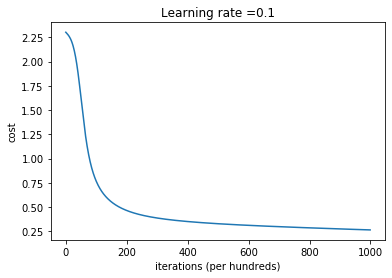

In [301]:
'''
--------------------- Create Model ----------------------
'''
layer_dimensions = [397,10]
learning_rate = 0.1
num_iterations = 1000
print_every = 100

x_training_images = np.array(x_training_images)
y_training_encoded = np.array( y_training_encoded)

weight_dict2, bias_dict2 = create_model(layer_dimensions, x_training_images, y_training_encoded, learning_rate, num_iterations, print_every)

In [302]:
'''
---------------------- Predict on test data ----------------------------
'''

y_hat = predict(weight_dict2, bias_dict2, x_test_images, layer_dimensions, y_test_encoded)

NN Dimensions: [397, 10]
Dataset shape: (784, 10000)
Labels Shape: (10, 10000)
Yhat shape: (10, 10000)
Final cost: [0.25705056]
Final accuracy: 92.73 %


In [303]:
y_hat_numbers = np.argmax(y_hat, axis = 0)


In [308]:
print(y_test_labels.T[:,:100])

[[7. 2. 1. 0. 4. 1. 4. 9. 5. 9. 0. 6. 9. 0. 1. 5. 9. 7. 3. 4. 9. 6. 6. 5.
  4. 0. 7. 4. 0. 1. 3. 1. 3. 4. 7. 2. 7. 1. 2. 1. 1. 7. 4. 2. 3. 5. 1. 2.
  4. 4. 6. 3. 5. 5. 6. 0. 4. 1. 9. 5. 7. 8. 9. 3. 7. 4. 6. 4. 3. 0. 7. 0.
  2. 9. 1. 7. 3. 2. 9. 7. 7. 6. 2. 7. 8. 4. 7. 3. 6. 1. 3. 6. 9. 3. 1. 4.
  1. 7. 6. 9.]]


In [305]:
print(y_hat_numbers[:100])

[7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4 9 6 6 5 4 0 7 4 0 1 3 1 3 6 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4 6 3 5 5 6 0 4 1 9 5 7 8 9 3 7 4 6 4 3 0 7 0 2 9
 1 7 3 7 9 7 7 6 2 7 8 4 7 3 6 1 3 6 4 3 1 4 1 7 6 9]


In [314]:
y_test_labels = np.squeeze(y_test_labels.T)
print(y_test_labels.shape)

(10000,)


In [315]:
print(y_hat_numbers.shape)

(10000,)


(1, 727)
[[  8  33  77  92 124 149 193 217 233 241 245 247 259 290 300 313 318 320
  321 340 341 352 362 381 412]]


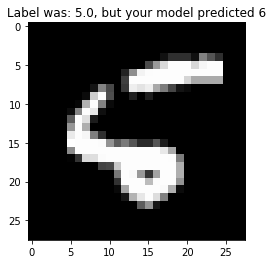

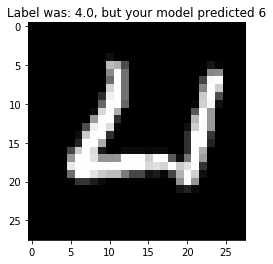

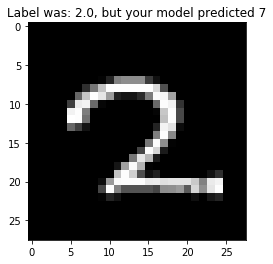

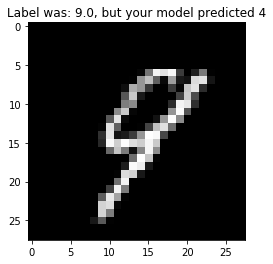

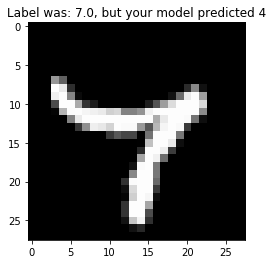

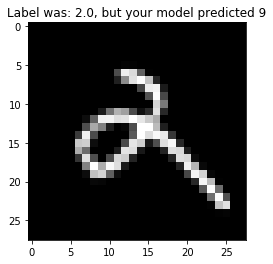

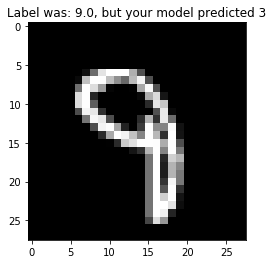

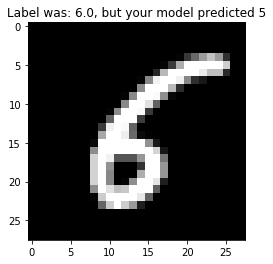

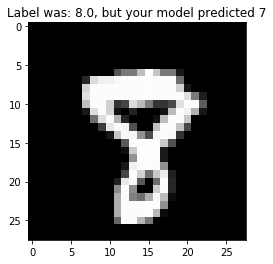

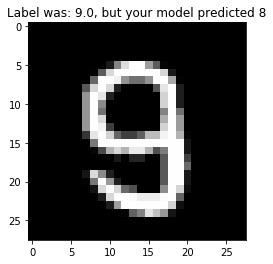

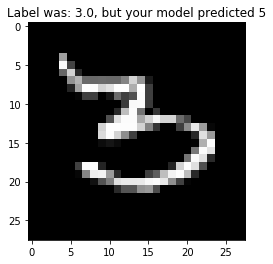

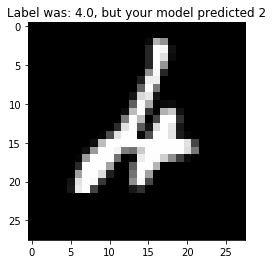

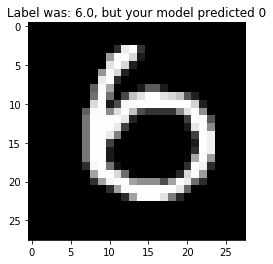

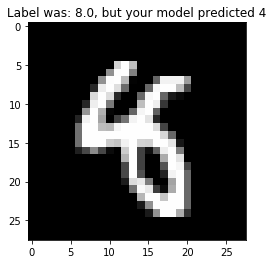

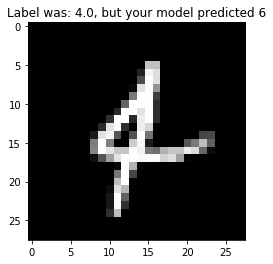

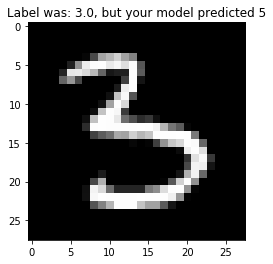

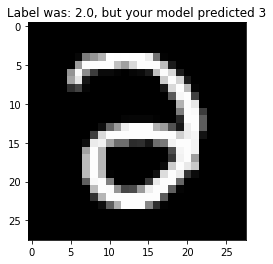

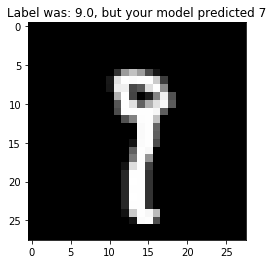

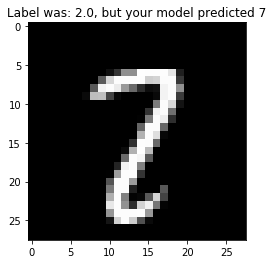

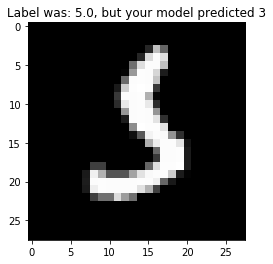

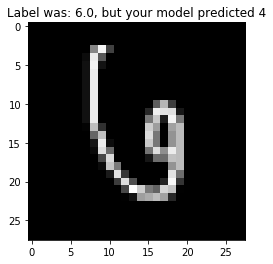

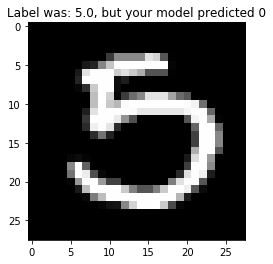

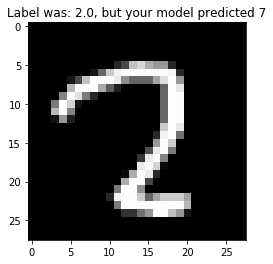

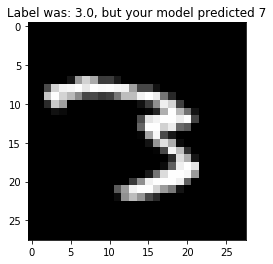

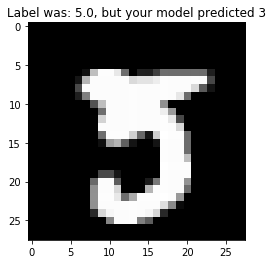

In [340]:
positions_where_prediction_wrong = (y_test_labels != y_hat_numbers)
positions_where_prediction_wrong = np.where(positions_where_prediction_wrong == True)
print(np.array(positions_where_prediction_wrong).shape)
positions_where_prediction_wrong = np.array(positions_where_prediction_wrong)[:, :25]
print(positions_where_prediction_wrong)
for i in np.array(positions_where_prediction_wrong)[0]:
    first_image = x_test_images[:,i]
    first_image = np.array(first_image, dtype='float')
    pixels = first_image.reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.title("Label was: " + str(y_test_labels[i]) + ", but your model predicted " + str(y_hat_numbers[i]))
    plt.show()


In [310]:
y_hat_numbers.reshape(1, 10000)

array([[7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6,
        6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2,
        3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4,
        6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 7, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3,
        6, 1, 3, 6, 4, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4,
        8, 7, 3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 4, 9, 0, 5, 8, 5, 6, 6,
        5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 9, 9, 9, 5, 5,
        1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5, 1, 4, 4, 7, 2, 3, 2, 7,
        1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1, 0, 3, 0, 3, 1, 6,
        4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5, 9, 3, 9, 0, 3, 5, 5, 5,
        7, 2, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 7, 7, 9, 2, 2, 4, 1, 5, 8,
        8, 7, 2, 5, 0, 2, 4, 2, 4, 1, 9, 5, 7, 7, 2, 8, 2, 0, 8, 5, 7, 7,
        9, 1, 8, 1, 8, 0, 3, 0, 1, 9, 9, 4, 1, 8, 2, 1, 2, 9, 7, 5, 9, 2,
        6, 4, 1, 5, 4, 2, 9, 2, 0, 4, 

In [312]:
first_image = x_test_images[:,i]
first_image = np.array(first_image, dtype='float')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.title("Label was: " + str(y_test_labels[i]) + ", but your model predicted " + str(y_hat_numbers[i]))
plt.show()

(10000,)

In [14]:
print("3")

3


In [ ]:
x_training_images = x_training_images.T
x_test_images = x_test_images.T
y_training_encoded = np.array(y_training_encoded).T
y_test_encoded = np.array(y_test_encoded).T